In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import os, shutil 

original_dataset_dir= 'D:/Documents/Grad-CAM/HCP_SYS866_2020/'

base_dir='D:/Documents/Grad-CAM/cerveaux_resnet/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    
train_dir=os.path.join(base_dir,'train/')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
validation_dir=os.path.join(base_dir,'validation/')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
    
test_dir=os.path.join(base_dir,'test/')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [4]:
train_homme_dir=os.path.join(train_dir,'homme')
if not os.path.exists(train_homme_dir):
    os.mkdir(train_homme_dir)

train_femme_dir = os.path.join(train_dir, 'femme')
if not os.path.exists(train_femme_dir):
    os.mkdir(train_femme_dir)
    
validation_homme_dir=os.path.join(validation_dir,'homme')
if not os.path.exists(validation_homme_dir):
    os.mkdir(validation_homme_dir)

validation_femme_dir = os.path.join(validation_dir, 'femme')
if not os.path.exists(validation_femme_dir):
    os.mkdir(validation_femme_dir)
    
test_homme_dir=os.path.join(test_dir,'homme')
if not os.path.exists(test_homme_dir):
    os.mkdir(test_homme_dir)

test_femme_dir = os.path.join(test_dir, 'femme')
if not os.path.exists(test_femme_dir):
    os.mkdir(test_femme_dir)

In [5]:
file= open('D:/Documents/Grad-CAM/labels.csv','r')

ligne= file.readlines()

file.close()

In [6]:
nom=[]
sexe=[]


for i in range (2,len(ligne)):
    
    li=str(ligne[i]).rstrip('\n')
    liste=li.split(',')
    nom.append(liste[0])
    sexe.append(liste[8])
    
print(len(nom))
print(len(sexe))

1205
1205


In [7]:
# Ajout d'images au dossier d'entrainement
for i in range(0, 850):
    fname='img'+nom[i]+'_T1w.png'
    src= os.path.join(original_dataset_dir, fname)
    if os.path.isfile(src)==True:
        if sexe[i]=='1':
            src= os.path.join(original_dataset_dir, fname)
            dst=os.path.join(train_homme_dir, fname)
            shutil.copyfile(src, dst)
        else:
            src= os.path.join(original_dataset_dir, fname)
            dst=os.path.join(train_femme_dir, fname)
            shutil.copyfile(src, dst)

In [8]:
# Ajout d'images au dossier de validation
for i in range(850, 1050):
    fname='img'+nom[i]+'_T1w.png'
    src= os.path.join(original_dataset_dir, fname)
    if os.path.isfile(src)==True:
        if sexe[i]=='1':
            src= os.path.join(original_dataset_dir, fname)
            dst=os.path.join(validation_homme_dir, fname)
            shutil.copyfile(src, dst)
        else:
            src= os.path.join(original_dataset_dir, fname)
            dst=os.path.join(validation_femme_dir, fname)
            shutil.copyfile(src, dst)

In [9]:
# Ajout d'images au dossier de test
for i in range(1050, 1205):
    fname='img'+nom[i]+'_T1w.png'
    src= os.path.join(original_dataset_dir, fname)
    if os.path.isfile(src)==True:
        if sexe[i]=='1':
            src= os.path.join(original_dataset_dir, fname)
            dst=os.path.join(test_homme_dir, fname)
            shutil.copyfile(src, dst)
        else:
            src= os.path.join(original_dataset_dir, fname)
            dst=os.path.join(test_femme_dir, fname)
            shutil.copyfile(src, dst)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=5)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
image_size = (150, 180)
batch_size = 16

training_set = train_datagen.flow_from_directory(
    "cerveaux/train",
    target_size=(image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 837 images belonging to 2 classes.


In [13]:
validation_set = validation_datagen.flow_from_directory(
    "cerveaux/validation",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 88 images belonging to 2 classes.


In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    "cerveaux/test",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
)

Found 84 images belonging to 2 classes.


## Définition du modèle

In [15]:
densenet = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150,150,3),
    pooling=None,
    classes=1000,
)

In [16]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# add a global spatial average pooling layer
x = densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [17]:
# this is the model we will train
densenet_model = Model(inputs=densenet.input, outputs=predictions)

In [18]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Densenet layers
for layer in densenet.layers:
    layer.trainable = False

In [19]:
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
start_time = time.time()

history = densenet_model.fit(x = training_set, validation_data=validation_set, shuffle=True, epochs=4)

print(time.time() - start_time)

Epoch 1/4
53/53 [==============================] - 23s 441ms/step - loss: 0.2695 - accuracy: 0.8901 - val_loss: 0.5127 - val_accuracy: 0.7614
Epoch 2/4
53/53 [==============================] - 23s 435ms/step - loss: 0.2914 - accuracy: 0.8877 - val_loss: 0.3099 - val_accuracy: 0.9091
Epoch 3/4
53/53 [==============================] - 23s 431ms/step - loss: 0.2653 - accuracy: 0.8925 - val_loss: 0.3621 - val_accuracy: 0.8409
Epoch 4/4
53/53 [==============================] - 23s 429ms/step - loss: 0.2296 - accuracy: 0.9092 - val_loss: 0.3923 - val_accuracy: 0.8523
94.13562107086182


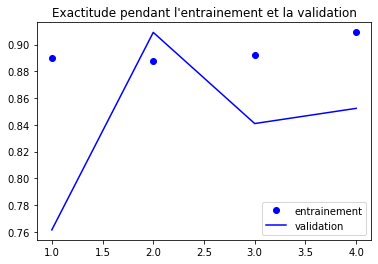

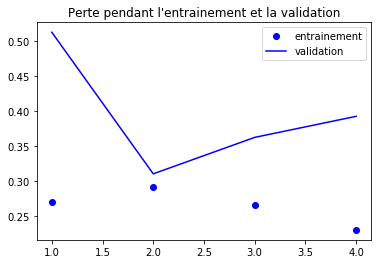

In [22]:
import matplotlib.pyplot as plt

acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs= range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='entrainement')
plt.plot(epochs, val_acc,'b', label='validation')
plt.title('Exactitude pendant l\'entrainement et la validation')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='entrainement')
plt.plot(epochs, val_loss, 'b', label='validation')
plt.title('Perte pendant l\'entrainement et la validation')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc= densenet_model.evaluate(test_set)

In [ ]:
y_true_labels = test_set.classes
true_labels = []

for label in y_true_labels:
    true_labels.append(np.array([np.float32(label)]))

In [ ]:
preds = densenet_model.predict(test_set)

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
predictions = []

for x in preds.tolist():
    predictions.append(x[1])
    """
    if x[0] > x[1]:
        predictions.append(0)
    else:
        predictions.append(1)
    """

In [ ]:
fpr, tpr, _ = roc_curve(true_labels, predictions)
auc = auc(fpr, tpr)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [24]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

#physical_devices = tf.config.list_physical_devices('GPU')

#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [30]:
#IMAGE_PATH = './cerveaux/test/homme/img829294_T1w.png'
#IMAGE_PATH = './cerveaux/test/homme/img826881_T1w.png'
IMAGE_PATH = './cerveaux_resnet/test/femme/img882730_T1w.png'
#IMAGE_PATH = './cerveaux/test/homme/img829294_T1w.png'
#IMAGE_PATH = './cerveaux/test/homme/img829294_T1w.png'
#IMAGE_PATH = './cerveaux/test/homme/img829294_T1w.png'
#IMAGE_PATH = './cerveaux/test/homme/img829294_T1w.png'
#IMAGE_PATH = './cerveaux/test/homme/img829294_T1w.png'
LAYER_NAME = 'conv5_block32_2_conv'
HOMME_CLASS_INDEX = 1
FEMME_CLASS_INDEX = 0

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(150, 150))
img = tf.keras.preprocessing.image.img_to_array(img)/255.

#model = keras.models.load_model('D:/Documents/Grad-CAM/models/4_couches_adam_98_07_categorical')
model = densenet_model

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, FEMME_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (150, 150))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

cv2.imwrite('cam.png', output_image)

True

In [27]:
densenet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

conv5_block15_1_bn (BatchNormal (None, 4, 4, 128)    512         conv5_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block15_1_relu (Activatio (None, 4, 4, 128)    0           conv5_block15_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block15_2_conv (Conv2D)   (None, 4, 4, 32)     36864       conv5_block15_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block15_concat (Concatena (None, 4, 4, 1376)   0           conv5_block14_concat[0][0]       
                                                                 conv5_block15_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block16_0_bn (BatchNormal (None, 4, 4, 1376)   5504        conv5_block15_concat[0][0]       
__________